# FFV Prediction + XAI (predict.py-aligned, Two Cells)

This notebook predicts FFV and visualizes Murcko fragment attributions using `predict.py`'s APIs. It also prints the exact checkpoint paths used (from best-5).

- Positive fragments (increase FFV): lemon green
- Negative fragments (decrease FFV): red
- Table: `substructure_smiles` with attribution scores (sorted by |score|)

Requirements
- `pip install -r requirements.txt` (PyTorch, PyG, RDKit, pillow, etc.)
- Artifacts under `output/` produced by this repo:
  - `output/polymer_properties_regression_final_eval/best_models.json`
  - `output/polymer_properties_regression_cv_results/cv*/checkpoints/*.ckpt`

How to use
1. Run the next cell once to load models and helpers.
2. Paste your SMILES in the final cell and run to see FFV + XAI.

Notes
- FFV only; no atom numbering on structures.
- Uses best‑5 ensemble from `best_models.json`.


In [1]:
# Load best-5 models, print their checkpoint paths, and define FFV helpers
import os, json
import numpy as np
import pandas as pd
from IPython.display import display
from rdkit import Chem
from rdkit.Chem import MolFragmentToSmiles
from config import Configuration
from predict import PredictionManager
import xai_viz

# Configure (align with predict.py; focus on FFV + Murcko)
config = Configuration()
config.output_dir = 'model_checkpoints'
config.substructure_type = 'murcko'
config.COMPUTE_XAI_FOR_ALL = True
config.PREDICT_REPR = 'auto'
config.USE_BIGSMILES = True
config.BIGSMILES_REQUIRED = False
config.CALIBRATE_FFV = False

# Palette: lemon green (pos) and red (neg)
xai_viz.PALETTES['lemon_red'] = {
    'pos': (0.90, 1.00, 0.30),
    'neg': (1.00, 0.20, 0.20),
}

# Initialize PredictionManager (CPU, best5 ensemble), loads from best_models.json
mgr = PredictionManager(config=config, input_csv='notebook_input.csv', device='cpu', num_workers=0, ensemble_type='best5')
print(f'Loaded models: {len(mgr.models)} (ensemble=best5)')

# Print the exact checkpoint paths used (derived from cv/fold and config paths)
ck_rows = []
for m in mgr.models:
    cv = int(m.get('cv', -1))
    fold = int(m.get('fold', -1))
    ckpt = os.path.join(
        config.output_dir,
        f"{config.task_name}_{config.task_type}_cv_results",
        f"cv{cv}",
        'checkpoints',
        f"{config.task_name}_{config.task_type}_cv{cv}_fold{fold}_best.ckpt"
    )
    ck_rows.append({'cv': cv, 'fold': fold, 'checkpoint_path': ckpt, 'exists': os.path.exists(ckpt)})
ck_df = pd.DataFrame(ck_rows).sort_values(['cv','fold']).reset_index(drop=True)

# Set pandas display options to show full paths
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

print('Checkpoints used:')
display(ck_df)

def ffv_predict_and_xai(smiles: str):
    """Predict FFV via predict.py and get FFV fragment attributions via predict.py.
    Returns (ffv_value, df_attr, ranked_masks) where ranked_masks contains atoms + delta for drawing.
    """
    # FFV prediction (exact predict.py entrypoint)
    pred = mgr.predict_molecule_with_confidence(smiles)
    ffv = pred.get('pred_FFV') or pred.get('ffv_pred')

    # Fragment attributions directly from predict.py
    res = mgr.analyze_property_attributions(smiles, 'FFV') or {}
    scaff = res.get('scaffolds', [])  # list of (attr, smiles)
    rows = [{'substructure_smiles': s, 'attribution': float(a)} for (a, s) in scaff]
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values(by='attribution', key=lambda s: s.abs(), ascending=False).reset_index(drop=True)

    # Map fragment SMILES -> atom indices for highlight (robust to ordering)
    ranked = []
    try:
        mol = Chem.MolFromSmiles(smiles)
        for _, row in df.iterrows():
            frag_smi = str(row['substructure_smiles'])
            attr = float(row['attribution'])
            if not frag_smi:
                ranked.append({'atoms': [], 'delta': attr, 'smiles': frag_smi})
                continue
            try:
                frag = Chem.MolFromSmiles(frag_smi)
                match = mol.GetSubstructMatch(frag)
                atoms = list(match) if match else []
            except Exception:
                atoms = []
            ranked.append({'atoms': atoms, 'delta': attr, 'smiles': frag_smi})
    except Exception:
        ranked = []

    return ffv, df, ranked


2025-12-05 11:17:38 - INFO - config - Starting configuration initialization...
2025-12-05 11:17:38 - INFO - config - Logger initialized for Configuration class.
2025-12-05 11:17:38 - INFO - config - All SMARTS patterns are valid.
2025-12-05 11:17:45 - INFO - config - Starting configuration initialization...
2025-12-05 11:17:45 - INFO - config - Logger initialized for Configuration class.
2025-12-05 11:17:45 - INFO - config - All SMARTS patterns are valid.
2025-12-05 11:17:45 - INFO - model - Starting model process...
2025-12-05 11:17:45 - INFO - data_module - Starting data_module process...
2025-12-05 11:17:45 - INFO - config - Starting configuration initialization...
2025-12-05 11:17:45 - INFO - config - Logger initialized for Configuration class.
2025-12-05 11:17:45 - INFO - config - All SMARTS patterns are valid.
2025-12-05 11:17:45 - INFO - predict - Initializing PredictionManager...
2025-12-05 11:17:45 - INFO - predict - Using device: cpu
2025-12-05 11:17:45 - INFO - predict - Usi

Loaded models: 5 (ensemble=best5)
Checkpoints used:


,cv,fold,checkpoint_path,exists
0,1,5,model_checkpoints\polymer_properties_regression_cv_results\cv1\checkpoints\polymer_properties_regression_cv1_fold5_best.ckpt,True
1,2,1,model_checkpoints\polymer_properties_regression_cv_results\cv2\checkpoints\polymer_properties_regression_cv2_fold1_best.ckpt,True
2,2,5,model_checkpoints\polymer_properties_regression_cv_results\cv2\checkpoints\polymer_properties_regression_cv2_fold5_best.ckpt,True
3,3,3,model_checkpoints\polymer_properties_regression_cv_results\cv3\checkpoints\polymer_properties_regression_cv3_fold3_best.ckpt,True
4,3,5,model_checkpoints\polymer_properties_regression_cv_results\cv3\checkpoints\polymer_properties_regression_cv3_fold5_best.ckpt,True


## Predict and Visualize
Paste your SMILES below and run the cell to see FFV prediction and fragment attributions.
- Output includes a molecule image (lemon green = positive, red = negative; no atom numbering) and a table of `substructure_smiles` with `attribution`.


SMILES: *CCCCCCCCOc1ccc(C(c2ccc(O*)cc2)(C(F)(F)F)C(F)(F)F)cc1*
Predicted FFV: 0.3642


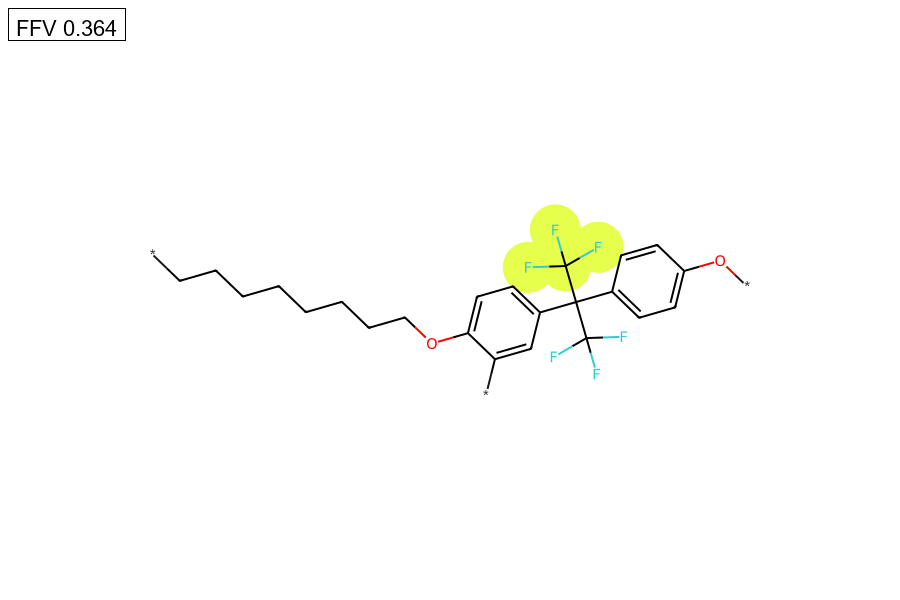

,substructure_smiles,attribution
0,FC(F)F,0.001914
1,FC(F)F,0.001914


In [2]:
# Enter a single SMILES here
smiles_string = '*CCCCCCCCOc1ccc(C(c2ccc(O*)cc2)(C(F)(F)F)C(F)(F)F)cc1*'  # e.g., '*CC(*)(CC(=O)Oc1ccc(OCCCCCCC)cc1)C(=O)Oc1ccc(OCCCCCCC)cc1*'

print('='*80)
print(f'SMILES: {smiles_string}')
ffv, df_attr, ranked_masks = ffv_predict_and_xai(smiles_string)
print(f'Predicted FFV: {ffv:.4f}' if ffv is not None else 'Predicted FFV: N/A')

img = xai_viz.draw_ffv_attributions(
    smiles_string, ranked_masks, legend=(f'FFV {ffv:.3f}' if ffv is not None else ''),
    show_atom_indices=False, palette='lemon_red'
)
display(img)
display(df_attr if df_attr is not None and not df_attr.empty else pd.DataFrame(columns=['substructure_smiles','attribution']))
